In [1]:
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as st
from matplotlib import pyplot as plt
import researchpy


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols


import correlation_test as ct

In [2]:
customer_df = pd.read_csv("../Data/customer_df_clean", sep=";", header=0)
transaction_df = pd.read_csv('../Data/transaction_product_df_clean', sep=";", encoding="UTF-8", header=0)
product_df = pd.read_csv('../Data/product_df_clean', sep=";", encoding="UTF-8", header=0)

In [3]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   client_id      8621 non-null   object
 1   sex            8621 non-null   object
 2   age            8621 non-null   int64 
 3   age_categorie  8621 non-null   object
 4   type_client    8621 non-null   object
dtypes: int64(1), object(4)
memory usage: 336.9+ KB


# 1 Etude d'une correlation entre le genre et la catégorie de livre acheté (quali x quali)

In [4]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


In [5]:
customer_df.shape[0]

8621

In [6]:
#Préparation de la jointure
customer_df.set_index('client_id', inplace=True)

# Nous prenons les clients qui ont au moins fait une transaction grâce au left only
transaction_customer = pd.merge(transaction_df, customer_df, on='client_id', how='left')

## Test statistique de l'indépendance avec qui-2 de Pearson

On pose l'hypothèse nulle **(H0)** qu'il n'y a pas de relation significative entre le sexe et la catégorie d'achat du client 

On modélise notre test statistiques par deux variables aléatoires X et Y avec : 
* **X** le sexe du client 
* **Y** la catégorie d'achat du client
* **Taille de l'échantillon (n)** : 8621 clients (>30)<br>  

Les différentes modalités de X sont : {"m" : homme, "f" : femme}  
Les différentes modalités de Y sont : {0,1,2} 

**objectif** : 
* Calculer la statistiques du qui-2 de Pearson pour déterminer l'indépendance ou non de X et Y.
* Vérifier la significativité du test en calculant le coefficient Cramer

In [7]:
transaction_customer

,id_prod,date,session_id,client_id,price,categ,sex,age,age_categorie,type_client
0,0_1518,2021-09-26,s_95811,c_6197,4.18,0,m,37,Adultes,particulier
1,0_1518,2021-05-06,s_30782,c_682,4.18,0,f,48,Senior,particulier
2,0_1518,2021-09-07,s_86219,c_4377,4.18,0,m,47,Senior,particulier
3,0_1518,2021-07-21,s_65278,c_191,4.18,0,f,58,Senior,particulier
4,0_1518,2021-04-29,s_27346,c_458,4.18,0,m,41,Adultes,particulier
...,...,...,...,...,...,...,...,...,...,...
315581,0_541,2021-03-08,s_3676,c_1869,1.99,0,f,37,Adultes,particulier
315582,0_1279,2021-06-23,s_52563,c_1025,20.99,0,m,38,Adultes,particulier
315583,0_1683,2021-12-24,s_139091,c_5508,2.99,0,f,48,Senior,particulier
315584,0_886,2021-03-17,s_7410,c_7219,21.82,0,f,56,Senior,particulier


**Observation** : D'après le tableau, les préférences d'achat des clients sont les mêmes suivant le sexe. 

**Exemple** : Les hommes et les femmes ont les mêmes préférences d'achat 


					 TEST D'INDEPENDANCE DU CHI-2 




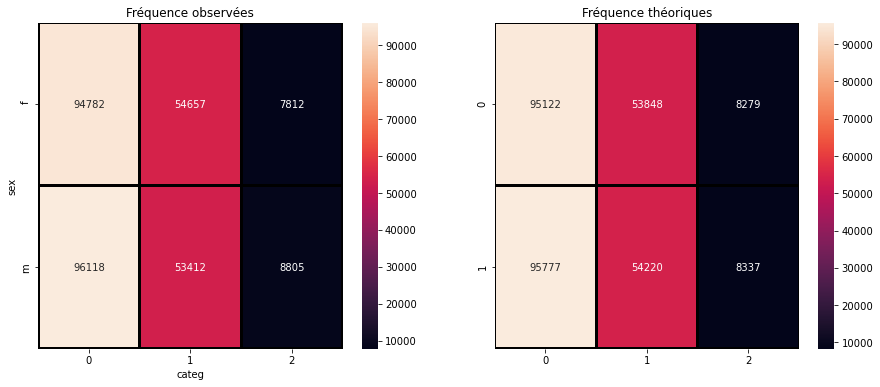



    		 ##### 0. Hypothèse du test  ##### 

    H0 : sex et categ sont indépendantes 

    H1 : sex et categ sont corrélées 
 
    
		 ##### 1. Paramètre du test ##### 

    Variables aléatoires étudiées : sex et categ

    Indice de confiance alpha : 0.05 

    Degré de liberté : 2

    
		 ##### 2. Résultat du test du Qui-2  ##### 

    Coefficient du qui-2 : 79.31011874358649

    p-value calculée : 5.998277244600357e-18


    
		 ##### 3. Conclusion du test  ##### 

    
H0 est rejetée : sex et categ sont corrélées significativement




					 TEST DE SIGNIFICATIVITE DE V CRAMER 


Le coefficient de Cramer est de : 0.0159 

    L'intensité du lien entre les variables est quasiement nulle





In [8]:
# Appelle de la fonction chi2
ct.chi2test(transaction_customer,'sex','categ')

# 2. Lien entre l'âge et la fréquence d'achat, le panier moyen et le montant total

Les variables que l'on étudie sont toutes des variables quantitatives. <br>
Les tests statistiques pour évaluer l'indépendance linéaire entre 2 variables sont ceux de **Pearson** ou de **Spearman**. <br>
Ces tests nous permettront d'obtenir la force des liens entre 2 variables grâce au coefficient lineaire (r²) de **Pearson** et **Spearman**

In [9]:
# Récupérer les données par client 


data = transaction_customer.groupby(by=['age'], as_index=False).agg({"id_prod" : "count",
                                             "price" : "sum"}).rename(columns={"id_prod" : "nombre d'achat",
                                                                              "price" : "montant total"})

data_parti = transaction_customer[transaction_customer["type_client"]=="particulier"].groupby(by=['age'], as_index=False).agg({"id_prod" : "count",
                                             "price" : "sum"}).rename(columns={"id_prod" : "nombre d'achat",
                                                                              "price" : "montant total"})

# Calcul le panier moyen par âgv

data["panier moyen"] = data["montant total"] / data["nombre d'achat"]
data_parti["panier moyen"] = data_parti["montant total"] / data_parti["nombre d'achat"]

In [10]:
data_parti

,age,nombre d'achat,montant total,panier moyen
0,18,6980,278682.40,39.925845
1,19,2055,83544.30,40.654161
2,20,2106,84648.84,40.194131
3,21,1949,81327.36,41.727737
4,22,2062,75945.11,36.830800
...,...,...,...,...
71,89,151,2456.65,16.269205
72,90,141,2346.54,16.642128
73,91,78,1308.66,16.777692
74,92,111,1973.72,17.781261


In [11]:
# Calcul du coefficient de corrélation selon la méthode de Pearson et Spearman
corr_pearson = data.corr(method="pearson")
corr_spearman = data.corr(method="spearman")
corr_pearson_parti = data_parti.corr(method="pearson")
corr_spearman_parti = data_parti.corr(method="spearman")

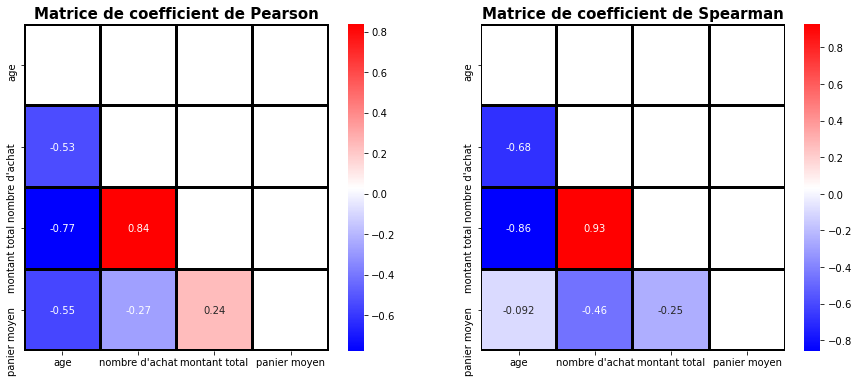

#######################################


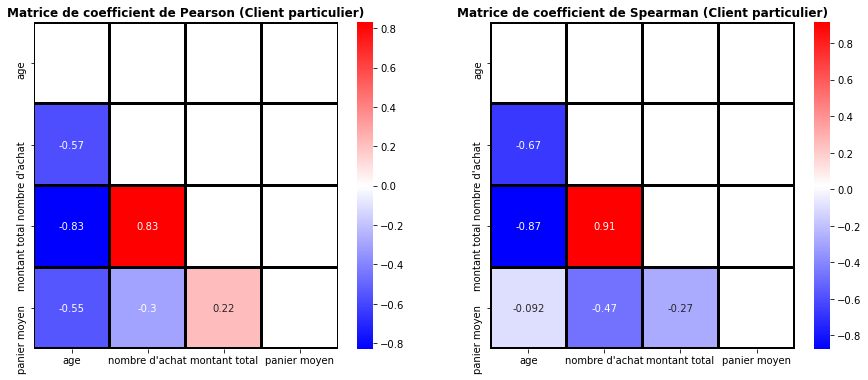

In [12]:
# Matrice de corrélation

# masque pour uniquement afficher la partie inférieure de la matrice symétrique
mask = np.triu(np.ones_like(corr_pearson, dtype=bool))

fig, ax = plt.subplots(1, 2 , figsize=(15,6))
sns.heatmap(corr_pearson,annot=True, ax=ax[0], cmap="bwr", mask=mask, linewidths=2, linecolor="k")
sns.heatmap(corr_spearman,annot=True, ax=ax[1], cmap="bwr", mask=mask, linewidths=2, linecolor="k")
ax[0].set_title("Matrice de coefficient de Pearson",fontsize=15, fontweight="bold")
ax[1].set_title("Matrice de coefficient de Spearman", fontsize=15, fontweight="bold")
plt.title
plt.show()

print("#######################################")
fig, ax = plt.subplots(1, 2 , figsize=(15,6))
sns.heatmap(corr_pearson_parti,annot=True, ax=ax[0], cmap="bwr", mask=mask, linewidths=2, linecolor="k")
sns.heatmap(corr_spearman_parti,annot=True, ax=ax[1], cmap="bwr", mask=mask, linewidths=2, linecolor="k")
ax[0].set_title("Matrice de coefficient de Pearson (Client particulier)",fontsize=12, fontweight="bold")
ax[1].set_title("Matrice de coefficient de Spearman (Client particulier)", fontsize=12, fontweight="bold")
plt.title
plt.show()

**Observation** : 

* D'après le test de Pearson, l'âge semble être corrélé avec le montant du panier moyen (**r²=-0.55**) ce qui n'est pas le cas du test de Spearman (**r²=-0.092**)
* On remarque une très forte corrélation entre le nombre d'achat et le montant total (**r²=0.93**) ce qui sous entend une liaison linéaire entre les 2 

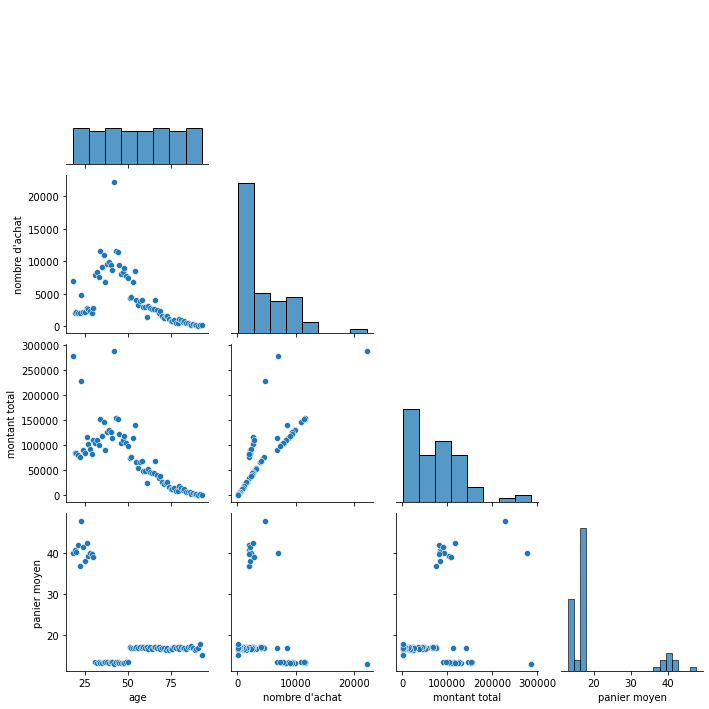

In [13]:
sns.pairplot(data, corner=True)
plt.show()

**Observation** : 

* Aucune variable aléatoire ne suit une loi Normale (Test de Pearson impossible)

## 2.1 Test statistique d'indépendance pour l'âge et le montant total des achats

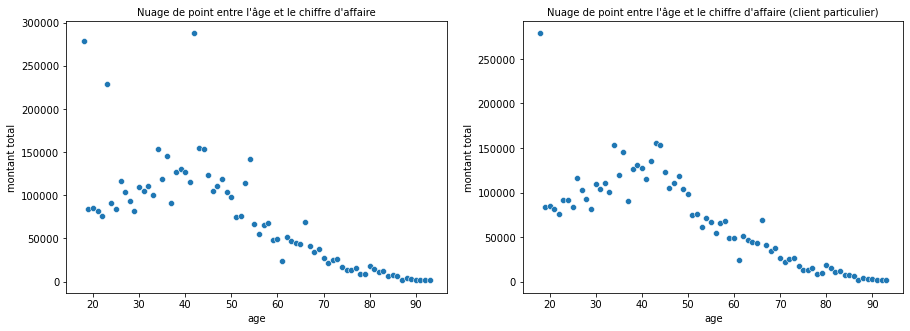

In [14]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=data, x="age", y="montant total", ax=ax[0])
sns.scatterplot(data=data_parti, x="age", y="montant total", ax=ax[1])
ax[0].set_title("Nuage de point entre l'âge et le chiffre d'affaire", fontsize=10)
ax[1].set_title("Nuage de point entre l'âge et le chiffre d'affaire (client particulier)", fontsize=10)
plt.show()

**Note** : Valeur remarquable des clients de 18 ans qui s'explique par des clients qui mineurs qui lors de l'inscription, triche en indiquant 18 ans pour effectuer des achats. Ce ne sont pas des clients **professionnels** et nous décidons donc de les garder pour nos tests de corrélation

## Test de normalité des variables aléatoires (Test de Shapiro)

In [15]:
ct.shapiro_test(data_parti['age'])
ct.shapiro_test(data_parti['montant total'])


					 TEST DE LA NORMALITE (TEST DE SHAPIRO) 



    	##### 0. Hypothèse du test #####

    H0 : age suit une loi normale 

    H1 : age ne suit pas une loi normale 

    
    	##### 1. Paramètre du test de Shapiro #####

    Variable aléatoire étudiée : age

    Indice de confiance : 0.05

    Taille de l'échantillon : 76

    
    	 #### 2. Résultat du test ####

    p-value de shapiro : 0.008753289468586445

    coefficient de shapiro : 0.9549233913421631
 
    
    	 #### 3. Conclusion du test ####

L'hypothèse nulle est rejetée 	 ==> age ne suit pas une loi normale



					 TEST DE LA NORMALITE (TEST DE SHAPIRO) 



    	##### 0. Hypothèse du test #####

    H0 : montant total suit une loi normale 

    H1 : montant total ne suit pas une loi normale 

    
    	##### 1. Paramètre du test de Shapiro #####

    Variable aléatoire étudiée : montant total

    Indice de confiance : 0.05

    Taille de l'échantillon : 76

    
    	 #### 2. Résultat du test ####

    p-value de shapir

## Test statistique de Spearman

In [16]:
ct.spearman_test(data_parti['age'], data_parti['montant total'])


					  TEST D'INDEPENDANCE DE SPEARMAN  


	##### 0. Hypothèse du test #####

    H0 : Les variables ('age', 'montant total') sont indépendantes

    H1 : Les variables ('age', 'montant total') sont corrélées

    	##### 1. Paramètre du test de Shapiro #####

    Variables aléatoires étudiées : ('age', 'montant total')

    Indice de confiance : 0.05

    Taille de l'échantillon : 76


    	 #### 2. Résultat du test ####

    coefficient de Spearman : -0.872153110047847

    p-value associée au test de Spearman : 1.115964940850988e-24

    	 #### 3. Conclusion du test ####


 --> ('age', 'montant total') présentent significativement une très forte corrélation négative.


## 2.2 Test d'indépendance de l'âge avec le nombre d'achat

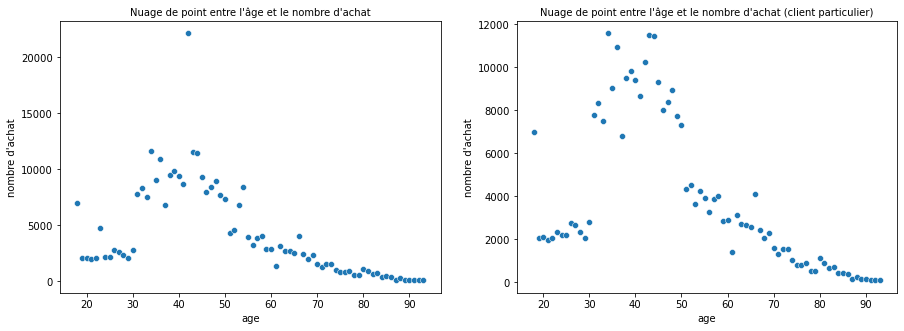

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=data, x="age", y="nombre d'achat", ax=ax[0])
sns.scatterplot(data=data_parti, x="age", y="nombre d'achat", ax=ax[1])
ax[0].set_title("Nuage de point entre l'âge et le nombre d'achat", fontsize=10)
ax[1].set_title("Nuage de point entre l'âge et le nombre d'achat (client particulier)", fontsize=10)
plt.show()

## Test de la normalité d'une variable

In [18]:
ct.shapiro_test(data_parti["nombre d'achat"])


					 TEST DE LA NORMALITE (TEST DE SHAPIRO) 



    	##### 0. Hypothèse du test #####

    H0 : nombre d'achat suit une loi normale 

    H1 : nombre d'achat ne suit pas une loi normale 

    
    	##### 1. Paramètre du test de Shapiro #####

    Variable aléatoire étudiée : nombre d'achat

    Indice de confiance : 0.05

    Taille de l'échantillon : 76

    
    	 #### 2. Résultat du test ####

    p-value de shapiro : 5.542508461076068e-07

    coefficient de shapiro : 0.8587468266487122
 
    
    	 #### 3. Conclusion du test ####

L'hypothèse nulle est rejetée 	 ==> nombre d'achat ne suit pas une loi normale




In [19]:
ct.spearman_test(data_parti['age'], data_parti["nombre d'achat"])


					  TEST D'INDEPENDANCE DE SPEARMAN  


	##### 0. Hypothèse du test #####

    H0 : Les variables ('age', "nombre d'achat") sont indépendantes

    H1 : Les variables ('age', "nombre d'achat") sont corrélées

    	##### 1. Paramètre du test de Shapiro #####

    Variables aléatoires étudiées : ('age', "nombre d'achat")

    Indice de confiance : 0.05

    Taille de l'échantillon : 76


    	 #### 2. Résultat du test ####

    coefficient de Spearman : -0.6731647300068353

    p-value associée au test de Spearman : 2.7051358253749183e-11

    	 #### 3. Conclusion du test ####


 --> ('age', "nombre d'achat") présentent significativement une forte corrélation négative.


## 2.3 Test d'indépendance de l'âge avec le panier moyen

In [20]:
data_parti['cluster_age'] = pd.cut(data_parti['age'], bins=[17,30,50,100], labels=["18-30","30-50","50+"])

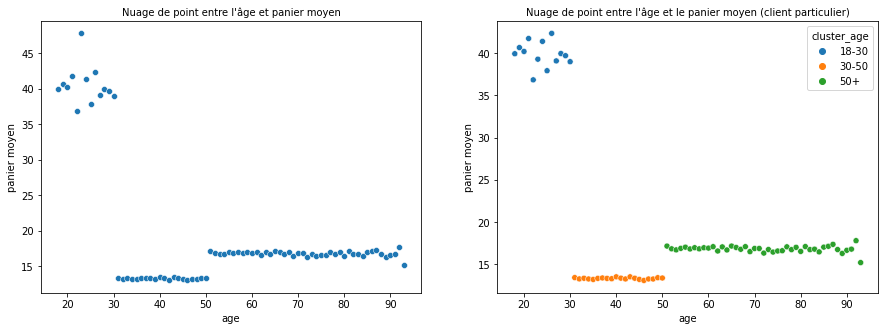

In [21]:
# Représentation graphique de l'âge avec le panier moyen



fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=data, x="age", y="panier moyen", ax=ax[0])
sns.scatterplot(data=data_parti, x="age", y="panier moyen", hue = "cluster_age", ax=ax[1])
ax[0].set_title("Nuage de point entre l'âge et panier moyen", fontsize=10)
ax[1].set_title("Nuage de point entre l'âge et le panier moyen (client particulier)", fontsize=10)
plt.show()

**Note** : On observe 3 types de comportement d'achat selon l'âge et le montant moyen du panier

* **Cluster 1** : Les clients de moins de 30 ans 
* **Cluster 2** : Les client entre 30 et 50 ans
* **Cluster 3** : Les clients de plus de 50 ans

In [22]:
ct.shapiro_test(data_parti["panier moyen"])


					 TEST DE LA NORMALITE (TEST DE SHAPIRO) 



    	##### 0. Hypothèse du test #####

    H0 : panier moyen suit une loi normale 

    H1 : panier moyen ne suit pas une loi normale 

    
    	##### 1. Paramètre du test de Shapiro #####

    Variable aléatoire étudiée : panier moyen

    Indice de confiance : 0.05

    Taille de l'échantillon : 76

    
    	 #### 2. Résultat du test ####

    p-value de shapiro : 5.581044524097245e-13

    coefficient de shapiro : 0.6054785251617432
 
    
    	 #### 3. Conclusion du test ####

L'hypothèse nulle est rejetée 	 ==> panier moyen ne suit pas une loi normale




In [23]:
ct.spearman_test(data_parti['age'], data_parti["panier moyen"])


					  TEST D'INDEPENDANCE DE SPEARMAN  


	##### 0. Hypothèse du test #####

    H0 : Les variables ('age', 'panier moyen') sont indépendantes

    H1 : Les variables ('age', 'panier moyen') sont corrélées

    	##### 1. Paramètre du test de Shapiro #####

    Variables aléatoires étudiées : ('age', 'panier moyen')

    Indice de confiance : 0.05

    Taille de l'échantillon : 76


    	 #### 2. Résultat du test ####

    coefficient de Spearman : -0.09238550922761449

    p-value associée au test de Spearman : 0.4273411301089961

    	 #### 3. Conclusion du test ####


 --> ('age', 'panier moyen') présentent une corrélation négative négligeable (ou nulle) peu significative


## 2.4 Test d'indépendance entre l'âge et la catégorie de livre à l'achat

In [24]:
client_parti = transaction_customer.loc[transaction_customer["type_client"]=="particulier", ['age','categ']]


In [25]:
client_parti

,age,categ
0,37,0
1,48,0
2,47,0
3,58,0
4,41,0
...,...,...
315581,37,0
315582,38,0
315583,48,0
315584,56,0


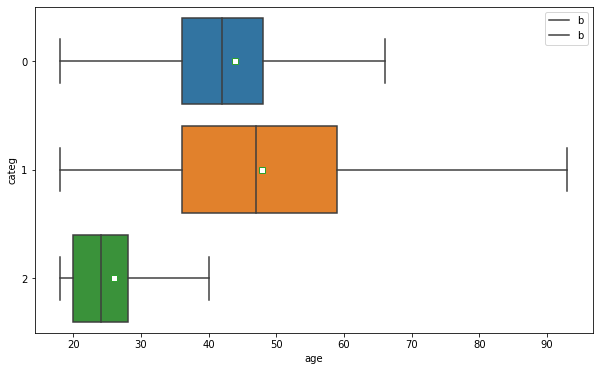

In [26]:
meanprops={"marker" : "s", "markerfacecolor" : "w"}

plt.subplots(1, figsize=(10,6))
sns.boxplot(data=client_parti, x='age',y='categ', showmeans=True, orient='h', showfliers=False, meanprops = meanprops)
plt.show()

**Test statistique d'ANOVA** pour tester l'indépendance d'une variable catégorique (catégorie de livre acheté) avec une variable quantitative (l'âge)

On pose : 

* **X** : désigne l'âge d'un client
* **Y**: désigne la catégorie du livre à l'achat du client

Hypothèse : 

* H0 : L'âge et la catégorie d'achat sont deux variables indépendantes (Pas d'effet d'âge sur la catégorie) <br>
* H1 : L'âge et la catégorie sont dépendantes 

**Statistique étudié** : le coefficient d'Anova pour tester la variance (l'écart) des moyennes de chacune des catégories

In [27]:
# Création d'un échantillon de 10000 transactions prises aléatoirement
sample = client_parti.sample(10000)
model = smf.ols('age ~ categ', data=sample).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('Test ANOVA entre Age et catégories')
print("\t Hypoyhèse nulle H0 : \t \t L'âge et la catégorie d'achat sont deux variables indépendantes (Pas d'effet d'âge sur la catégorie)")
print("\t Hypoyhèse alternative H1 : \t L'âge et la catégorie sont dépendantes")
print('')
print('Table ANOVA :')
print(anova_table)
p_value = anova_table['PR(>F)'][0]
print('p-value :', p_value)
if p_value < 0.05:
    print("L'hypothèse nulle est rejetée \t ==> H1: Au moins une catégorie a une moyenne d'age significativement différente.")
else:
    print("On ne peut pas rejeter l'hypothèse nulle H0 (Pas d'effet d'age sur les catégories).")

Test ANOVA entre Age et catégories
	 Hypoyhèse nulle H0 : 	 	 L'âge et la catégorie d'achat sont deux variables indépendantes (Pas d'effet d'âge sur la catégorie)
	 Hypoyhèse alternative H1 : 	 L'âge et la catégorie sont dépendantes

Table ANOVA :
                sum_sq      df          F        PR(>F)
categ     5.974425e+03     1.0  31.706788  1.841366e-08
Residual  1.883896e+06  9998.0        NaN           NaN
p-value : 1.8413655607396472e-08
L'hypothèse nulle est rejetée 	 ==> H1: Au moins une catégorie a une moyenne d'age significativement différente.
